## performance test of Mask R-CNN model

This code is for google colaboratory. Check that **GPU is available** before running this code

In [1]:
!nvidia-smi

Fri Dec 24 07:39:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
import os
os.chdir('/content/drive/My Drive/ai_ichthyolith/')

Mounted at /content/drive


In [3]:
!pip install keras==2.3.1
%tensorflow_version 1.x
!pip install h5py==2.10.0

TensorFlow 1.x selected.


In [4]:
# https://qiita.com/skiing_LAL10/items/78be5e7aaaffe461c3ac (in japanese)
from google.colab import output
def beep():
    output.eval_js('new Audio(\
    "https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg")\
    .play()') 

## Initial settings

In [5]:
site = 'Site_1179' #@param {type:'string'}
sample_ID = '1179C_24_05_75' #@param {type:'string'}

BASE_DIR_NAME = '20211219_dataset1' # @param {type:'string'}
# BASE_DIR_NAME = '20210817_CopyPaste_fullsize' # @param {type:'string'}

class_names = ['bg', 'tooth',] #@param {type:'raw'}
stride = 640 # @param {type:'integer'}
assert stride % 64 == 0
MAX_GT_INSTANGES = 75# @param {type:'integer'}

ROOT_DIR = '/content/drive/My Drive/ai_ichthyolith/' # on google colab, absolute path should be specified
DEVICE = '/gpu:0' # '/cpu:0' or '/gpu:0'

### libraries and paths

In [6]:
# MODEL_NAME = 'mask_rcnn_ichthyolith_{:0=4}.h5'.format(best_epoch)
# TEST_DATASET_DIR = ROOT_DIR + 'data/images/test'
hirox_dir = ROOT_DIR + 'data/images'

import os
import sys
import time
import math
from glob import glob
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imread, imsave
from PIL import Image, ImageOps
Image.MAX_IMAGE_PIXELS = 1000000000

sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn import model as modellib
from mrcnn.config import Config

from functions.utils import load_pickle, save_pickle
from functions.detect import detect
%matplotlib inline

MODEL_DIR = os.path.join(ROOT_DIR, 'models')
TEST_MODE = 'inference'

# DETECTIONS_DIR = os.path.join(ROOT_DIR, 'results', BASE_DIR_NAME, MODEL_NAME[-7:-3])

annot_base_dir = f'{ROOT_DIR}data/annotations/{sample_ID}/'
os.makedirs(annot_base_dir, exist_ok = True)

Using TensorFlow backend.


### overwriting Config

In [7]:
class InferenceConfig(Config):
    """Configuration for detecting ichthyolith in the give image."""
    # Give the configuration a recognizable name
    NAME = 'ichthyolith'
    
    # Batch size  GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # Number of classes (including background)
    NUM_CLASSES = len(class_names)
    
    # Skip detections with < DETECTION_MIN_CONFIDENCE
    DETECTION_MIN_CONFIDENCE = 0
    
    # change IMAGE_MIN_DIM and IMAGE_MAX_DIM according to the model version
    IMAGE_MIN_DIM = stride
    IMAGE_MAX_DIM = stride
    
    MAX_GT_INSTANGES = MAX_GT_INSTANGES
    TRAIN_ROI_PER_IMAGE = 400
    
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

### test detection

In [8]:
# # os.chdir(TEST_DATASET_DIR)
# testImg_name = '1179C_24_05_75_005_3360_10920.jpg' #@param {type:'string'}
# testImg_path = os.path.join(hirox_dir, testImg_name)
# assert os.path.exists(testImg_path)
# ignore_classids = []
# test_epochs = [40, 80] #@param {type:'raw'}

# for epoch in test_epochs:
#     print()
#     print(f"##### epoch {epoch} #####")
#     MODEL_NAME_test = 'mask_rcnn_ichthyolith_{:0=4}.h5'.format(epoch)
#     MODEL_PATH_test = os.path.join(MODEL_DIR, BASE_DIR_NAME, MODEL_NAME_test)

#     # load model
#     t0 = time.time()
#     model = modellib.MaskRCNN(mode="inference", 
#                               config=InferenceConfig(),
#                               model_dir=MODEL_DIR)
#     model.load_weights(MODEL_PATH_test, by_name=True)
#     t1 = time.time()
#     print(f'load weight: {t1 - t0:.3f} s')

#     img = imread(testImg_path)
#     t2 = time.time()
#     print(f'imread: {t2 - t1:.3f} s')

#     filename = testImg_path.split('/')[-1]
#     result = detect(model, img, filename, ignore_classids = ignore_classids)
#     bbox = result['rois']
#     masks = result['masks']
#     class_ids = result['class_ids']
#     scores = result['scores']

#     t3 = time.time()
#     print(f'detect: {t3 - t2:.3f} s')

#     for i, cl in enumerate(class_names):
#         if cl != 'bg':
#             bbox_cl = bbox[class_ids == i]
#             masks_cl = masks[:, :, class_ids == i]
#             class_ids_cl = class_ids[class_ids == i]
#             scores_cl = scores[class_ids == i]    
#             visualize.display_instances(img, bbox_cl, masks_cl, class_ids_cl, 
#                                     class_names, scores=scores_cl, title = f'class: {cl}', figsize=[8, 8])
#     t4 = time.time()
#     print(f'visualize: {t4 - t3:.3f} s')


In [9]:
best_epoch =   80#@param{"type":"integer"}
MODEL_NAME = 'mask_rcnn_ichthyolith_{:0=4}.h5'.format(best_epoch)
MODEL_PATH = os.path.join(MODEL_DIR, BASE_DIR_NAME, MODEL_NAME)
DETECTIONS_DIR = os.path.join(ROOT_DIR, 'results', BASE_DIR_NAME, MODEL_NAME[-7:-3])
avoid_ReDetection = True #@param {type:'boolean'}

### detection of slide images

In [10]:
slide_No =  [1, 2, 3, 4, 5, 6]# @param {type:'raw'} detect from all the slide available
ignore_classids = [] #@param {type:'raw'}

###############################################

site_name = site
from functions.detect import batch_detect_microscopes
hirox_img_dir = os.path.join(hirox_dir, site_name, sample_ID)
assert os.path.exists(hirox_img_dir), hirox_img_dir
batch_detect_microscopes(MODEL_PATH, hirox_img_dir, config, DETECTIONS_DIR,
                         device=DEVICE, time_output=False, ignore_classids = ignore_classids, 
                         save_points = True, save_mask = False, slide_No=slide_No, 
                         avoid_ReDetection=avoid_ReDetection)

beep()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights /content/drive/My Drive/ai_ichthyolith/models/20211219_dataset1/mask_rcnn_ichthyolith_0080.h5
following slide will be detected
['1179C_24_05_75_001', '1179C_24_05_75_002', '1179C_24_05_75_003', '1179C_24_05_75_004', '1179C_24_05_75_005', '1179C_24_05_75_006']

start detecting.
slide name: 1179C_24_05_75_001
skipped re-detection: /content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/1179C_24_05_75_001.pkl

start detecting.
slide name: 1179C_24_05_75_002
skipped re-detection: /content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/1179C_24_05_75_002.pkl

start detecting.
slide name: 1179C_24_05_75_003
skipped re-detection: /content/drive/My Drive

## process data

In [11]:
from functions.utils import load_json, load_pickle
from functions.process_excel import ExcelDataProcessor
from functions.process_pickle import batch_convert_to_eval_format

In [12]:
base_pickle_dir = f"{ROOT_DIR}results/{BASE_DIR_NAME}/{best_epoch:0=4}"
os.chdir(base_pickle_dir)
print('following pickles file exist\n')
path_list = sorted(glob(os.path.join(base_pickle_dir, f"{sample_ID}*.pkl")))
path_list

following pickles file exist



['/content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/1179C_24_05_75_001.pkl',
 '/content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/1179C_24_05_75_002.pkl',
 '/content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/1179C_24_05_75_003.pkl',
 '/content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/1179C_24_05_75_004.pkl',
 '/content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/1179C_24_05_75_005.pkl',
 '/content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/1179C_24_05_75_006.pkl',
 '/content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/1179C_24_05_75_hirox_final_evaluation.pkl']

In [13]:
# non maximum suppression

display_detail = False
# slide_No = [1, 2, 3, 4, 5, 6] #@param {type:'raw'}
slide_No = slide_No #@param {type:'raw'}
# slide_No = None #@param {type:'raw'}

###############################################

if slide_No is None:
    use_pickle_names = sample_ID
else:
    use_pickle_names = [f'{sample_ID}_{num:0=3}.pkl' for num in slide_No]


if type(use_pickle_names) == str:
    if use_pickle_names == 'all':
        os.chdir(base_pickle_dir)
        use_pickle_names = [pk for pk in glob('*.pkl') if 'final_evaluation' not in pk]
    else:
        os.chdir(base_pickle_dir)
        use_pickle_names = [pk for pk in glob(use_pickle_names + '*.pkl') if 'final_evaluation' not in pk]

use_pickle_names.sort()
print("use_pickle_names:", use_pickle_names)

path_list = [path for path in path_list if os.path.basename(path) in use_pickle_names]

# path_list = ['/content/drive/My Drive/ai_ichthyolith/results/logs_dataset_tooth_denticle_with_handpicked_20200723/0080/MR15_PC11_24_04_26_009.pkl',
#  '/content/drive/My Drive/ai_ichthyolith/results/logs_dataset_tooth_denticle_with_handpicked_20200723/0080/MR15_PC11_24_04_26_010.pkl',]


save_pickle_path = os.path.join(base_pickle_dir, f'{sample_ID}_final_evaluation.pkl')

eval_data = batch_convert_to_eval_format(path_list, save_path=save_pickle_path, 
                                         save_croppedName = True, rois_dtype = 'int32', IoU=0.2)

if display_detail:
    print()
    print(f'eval_data size     : {len(eval_data)}')
    for i in range(len(eval_data)):
        print(f'filename           : {eval_data[i][0]["filename"]}')
        print(f'shape of rois      : {eval_data[i][0]["rois"].shape}')
        print(f'dtype of rois      : {eval_data[i][0]["rois"].dtype}')
        print(f'shape of masks     : {eval_data[i][0]["masks"].shape}')
        print(f'dtype of masks     : {eval_data[i][0]["masks"].dtype}')
        print(f'shape of class_ids : {eval_data[i][0]["class_ids"].shape}')
        print(f'dtype of class_ids : {eval_data[i][0]["class_ids"].dtype}')
        print(f'shape of scores    : {eval_data[i][0]["scores"].shape}')
        print(f'dtype of scores    : {eval_data[i][0]["scores"].dtype}')
        print(f'rois               : {eval_data[i][0]["rois"][:5, :]}')
        print()

use_pickle_names: ['1179C_24_05_75_001.pkl', '1179C_24_05_75_002.pkl', '1179C_24_05_75_003.pkl', '1179C_24_05_75_004.pkl', '1179C_24_05_75_005.pkl', '1179C_24_05_75_006.pkl']

removed 286 rois by non maximum suppression.
before: 986
after : 700

removed 500 rois by non maximum suppression.
before: 1754
after : 1254

removed 374 rois by non maximum suppression.
before: 1334
after : 960

removed 973 rois by non maximum suppression.
before: 3399
after : 2426

removed 390 rois by non maximum suppression.
before: 1597
after : 1207

removed 401 rois by non maximum suppression.
before: 1668
after : 1267
created detections results for evaluation.


## inspect retults

In [14]:
MODEL_PATH = os.path.join(MODEL_DIR, BASE_DIR_NAME, MODEL_NAME)
DETECTIONS_PATH = os.path.join(DETECTIONS_DIR, f'{sample_ID}_final_evaluation.pkl')
GTS_PATH = f'/content/drive/My Drive/ai_ichthyolith/results/gts/{sample_ID}_final_eval_gts.pkl'

print(f'MODEL_PATH      : {os.path.exists(MODEL_PATH)}: {MODEL_PATH}')
print(f'DETECTIONS_PATH : {os.path.exists(DETECTIONS_PATH)}: {DETECTIONS_PATH}')
print(f'GTS_PATH        : {os.path.exists(GTS_PATH)}: {GTS_PATH}')

MODEL_PATH      : True: /content/drive/My Drive/ai_ichthyolith/models/20211219_dataset1/mask_rcnn_ichthyolith_0080.h5
DETECTIONS_PATH : True: /content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/1179C_24_05_75_hirox_final_evaluation.pkl
GTS_PATH        : True: /content/drive/My Drive/ai_ichthyolith/results/gts/1179C_24_05_75_hirox_final_eval_gts.pkl


In [15]:
classes = [class_names[i] for i in range(len(class_names)) if i not in ignore_classids]
classes

['bg', 'tooth']

In [16]:
from functions.process_pickle import extract_by_scores, extract_specific_size

score_threshold = 0
# score_threshold = score_threshold
min_size = None
max_size = None

detections = load_pickle(DETECTIONS_PATH)
detections = extract_by_scores(detections, score_threshold)

gts = load_pickle(GTS_PATH)

# todo: cropped_imgName を移す
# gts = extract_specific_size(gts, min_size=min_size, max_size=max_size)

num_detections = [0 for _ in range(len(classes))]
num_gts = [0 for _ in range(len(classes))]

for i in range(len(detections)):
    assert detections[i][0]['filename'] == gts[i][0]['filename'], detections[i][0]['filename']
    class_ids = detections[i][0]['class_ids']
    gt_class_ids = gts[i][0]['gt_class_id']
    num_detections_per_image = [0 for _ in range(len(classes))]
    num_gts_per_image = [0 for _ in range(len(classes))]
    for class_id in class_ids:
        num_detections[class_id] += 1
        num_detections_per_image[class_id] += 1
    for gt_class_id in gt_class_ids:
        num_gts[gt_class_id] += 1
        num_gts_per_image[gt_class_id] += 1
    print('\n---------------------------------------\n')
    print(f'detection ({detections[i][0]["filename"]})')
    for idx, c in enumerate(classes):
        print(f'{c:8}: {num_detections_per_image[idx]}')
    print()
    print(f'gts ({gts[i][0]["filename"]})')
    for idx, c in enumerate(classes):
        print(f'{c:8}: {num_gts_per_image[idx]}')
        
print('\n=======================================\n')

print('detection (total)')
for idx, c in enumerate(classes):
    print(f'{c:8}: {num_detections[idx]}')

print()
print('gts (total)')
for idx, c in enumerate(classes):
    print(f'{c:8}: {num_gts[idx]}')

print('\n=======================================\n')


---------------------------------------

detection (1179C_24_05_75_001.jpg)
bg      : 0
tooth   : 700

gts (1179C_24_05_75_001.jpg)
bg      : 0
tooth   : 23

---------------------------------------

detection (1179C_24_05_75_002.jpg)
bg      : 0
tooth   : 1254

gts (1179C_24_05_75_002.jpg)
bg      : 0
tooth   : 23

---------------------------------------

detection (1179C_24_05_75_003.jpg)
bg      : 0
tooth   : 960

gts (1179C_24_05_75_003.jpg)
bg      : 0
tooth   : 85

---------------------------------------

detection (1179C_24_05_75_004.jpg)
bg      : 0
tooth   : 2426

gts (1179C_24_05_75_004.jpg)
bg      : 0
tooth   : 176

---------------------------------------

detection (1179C_24_05_75_005.jpg)
bg      : 0
tooth   : 1207

gts (1179C_24_05_75_005.jpg)
bg      : 0
tooth   : 49

---------------------------------------

detection (1179C_24_05_75_006.jpg)
bg      : 0
tooth   : 1267

gts (1179C_24_05_75_006.jpg)
bg      : 0
tooth   : 78


detection (total)
bg      : 0
tooth   : 7814


### Precision, Recall, AP, f_score, TP, FP

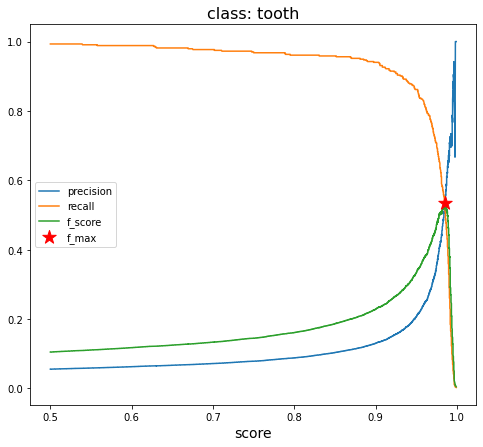

precision (score > 0) : 0.0552
recall    (score > 0) : 0.9931
score threshold       : 0.9854
f_max                 : 0.5333
precision at f_max    : 0.5416
recall at f_max       : 0.5253


In [18]:
assign_dict = {1: 1}
mode = 'box'
score_threshold = 0
min_size = None
# min_size = 0.003
max_size = None
check_slide_index = None
rough_class_names = ['bg', 'tooth']

#######################################

pd.options.display.precision = 4
from functions.compute_ap import evaluate
from functions.process_pickle import extract_by_scores, extract_specific_size, convert_detections_labels, convert_gts_labels

# データの読み込み
detections = load_pickle(DETECTIONS_PATH)
gts = load_pickle(GTS_PATH)

df = pd.DataFrame()
num_classes = len(set([v for v in assign_dict.values()]))

# if len(assign_dict) != 0:
#     detections = convert_detections_labels(detections, assign_dict)
#     gts = convert_gts_labels(gts, assign_dict)
    
if check_slide_index is not None:
    detections = [detections[check_slide_index]]
    gts = [gts[check_slide_index]]
    print(f'filename: {detections[0][0]["filename"]}')
    
class_ids = [i+1 for i in range(num_classes)]

APs = []
precisions = []
recalls = []

detections = extract_by_scores(detections, score_threshold)
gts = extract_specific_size(gts, min_size=min_size, max_size=max_size)

score_class_list = []
for j in range(len(detections)):
    scores = detections[j][0]['scores']
    class_ids2 = detections[j][0]['class_ids']
    for item in np.array([scores, class_ids2]).T.tolist():
        score_class_list.append(item)
score_class_list.sort(key=lambda x: x[0], reverse=True)

if num_classes == 1:
    fig, ax_now = plt.subplots(1,1, figsize = (8, 7))
else:
    fig, ax = plt.subplots(1, max(2, len(class_ids)), figsize=(min(8 * max(2, len(class_ids)),17), 7))

for i, class_id in enumerate(class_ids):
    AP, precision, recall, f_score, TP, FP = evaluate(detections, gts, label=class_id, iou_threshold=0.2, mode=mode)
    APs.append(AP)
    precisions.append(precision)
    recalls.append(recall)
    score_list_cl = [sc[0] for sc in score_class_list if sc[1] == class_id]
    df.loc[f'recall ({mode})', rough_class_names[class_id]] = recall[-1]
    df.loc[f'precision ({mode})', rough_class_names[class_id]] = precision[-1]
    df.loc[f'AP ({mode})', rough_class_names[class_id]] = AP
    df.loc[f'f_score_max ({mode})', rough_class_names[class_id]] = np.max(f_score)
    fmax_index = np.argmax(f_score)
    df.loc[f'index (f max) ({mode})', rough_class_names[class_id]] = fmax_index
    df.loc[f'score_threshold', rough_class_names[class_id]] = score_list_cl[fmax_index]
    df.loc[f'precision at f_max', rough_class_names[class_id]] =  precision[fmax_index]
    df.loc[f'recall at f_max', rough_class_names[class_id]] =  recall[fmax_index]
    df.loc[f'TP ({mode})', rough_class_names[class_id]] = int(TP[-1])
    df.loc[f'FP ({mode})', rough_class_names[class_id]] = int(FP[-1])

    if num_classes >= 2:
        ax_now = ax[i]
    ax_now.plot(score_list_cl, precision, label = 'precision', zorder = 1)
    ax_now.plot(score_list_cl, recall, label = 'recall', zorder = 2)
    ax_now.plot(score_list_cl, f_score, label = 'f_score', zorder = 3)
    ax_now.scatter(score_list_cl[fmax_index], f_score[fmax_index], marker='*', s = 200, c = 'r', label = 'f_max', zorder = 5)
    ax_now.set_title(f'class: {rough_class_names[class_id]}', fontsize = 16)
    ax_now.set_xlabel('score', fontsize = 14)
    ax_now.legend()
    if check_slide_index is not None:
        print(f'gt_count      ({mode}) class{class_id:2d}: {len(gts[0][0]["gt_class_id"][gts[0][0]["gt_class_id"]==class_id])}')
    
plt.savefig(os.path.join(DETECTIONS_DIR, 'performances.pdf'))
plt.show()
APs = np.array(APs)
precisions = np.array(precisions)
recalls = np.array(recalls)
# print(f'mAP ({mode}): {round(np.mean(APs), 3)}')

df.loc['(settings)', rough_class_names[1]] = ''
df.loc['model path', rough_class_names[1]] = MODEL_PATH
df.loc['detections dir', rough_class_names[1]] = DETECTIONS_DIR
df.loc['sample ID', rough_class_names[1]] = sample_ID
df.loc[f'mAP ({mode})'] = np.mean(APs)

save_excel_path = os.path.join(DETECTIONS_DIR, f'{sample_ID}_performances.xlsx')
df.to_excel(save_excel_path)
score_threshold = df.loc['score_threshold', 'tooth']

print('precision (score >=0) :', round(df.loc['precision (box)', rough_class_names[1]], 4))
print('recall    (score >=0) :', round(df.loc['recall (box)', rough_class_names[1]], 4))
print('score threshold       :', round(score_threshold, 4))
print('f_max                 :', round(df.loc[f'f_score_max ({mode})', rough_class_names[1]], 4))
print('precision at f_max    :', round(df.loc['precision at f_max', rough_class_names[1]], 4))
print('recall at f_max       :', round(df.loc['recall at f_max', rough_class_names[1]], 4))

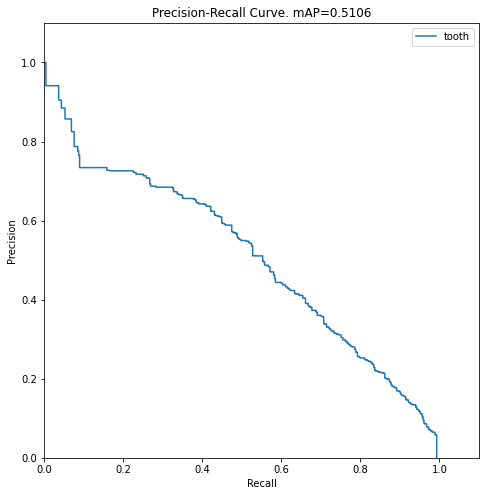

In [20]:
_, ax = plt.subplots(1, figsize=(8, 8))
ax.set_title(f'Precision-Recall Curve. mAP={np.mean(APs):.4}')
ax.set_ylim(0, 1.1)
ax.set_xlim(0, 1.1)
ax.set_aspect('equal')

for class_id, AP, precision, recall in zip(class_ids, APs, precisions, recalls):
    m_recall = np.concatenate(([0.], recall, [recall[-1]]))
    m_precision = np.concatenate(([0.], precision, [0.]))
    
    for i in range(m_precision.size - 1, 0, -1):
        m_precision[i-1] = np.maximum(m_precision[i-1], m_precision[i])
    
    ax.plot(m_recall, m_precision, label=classes[class_id])
    ax.legend()

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.savefig(os.path.join(DETECTIONS_DIR, f'{sample_ID}_PR_curve.pdf'))
plt.show()

### save TP / FP / FN 

In [22]:
score_threshold = 0

In [23]:
from functions.compute_ap import evaluate, get_TP_FP_FN_index
from functions.process_pickle import extract_by_scores, extract_specific_size, convert_detections_labels, convert_gts_labels
from functions.process_pickle import get_top_left_coordinate, get_original_slide_name, convert_to_rel_rois

mode = 'box'
class_id = 1
min_size = None
max_size = None
check_slide_index = None

def get_sub_detections(det, label, index):
    sub_det = []
    for i in range(len(det)):
        idx = np.where(det[i][0]['class_ids'] == label)[0]
        filename = det[i][0]['filename']
        rois = det[i][0]['rois'][idx]
        scs = det[i][0]['scores'][..., idx]
        class_ids = det[i][0]['class_ids'][idx]
        contents = {'filename': filename, 'rois': rois[index[i]], 
                    'scores': scs[..., index[i]], 'class_ids': class_ids[index[i]]}
        for key in ['all_points_xs', 'all_points_ys', 'cropped_imgName']:
            if key in det[i][0].keys():
                contents[key] = [[det[i][0][key][idx_] for idx_ in idx][id_] for id_ in index[i]]
        sub_det.append([contents])
    return sub_det

def get_sub_gts(gts, label, index):
    sub_gts = []
    for i in range(len(gts)):
        gt_index = np.where(gts[i][0]['gt_class_id'] == label)[0]
        filename = gts[i][0]['filename']
        gt_boxes = gts[i][0]['gt_bbox'][gt_index]
        gt_class_id = gts[i][0]['gt_class_id'][gt_index]
        contents = {'filename': filename, 'gt_bbox': gt_boxes[index[i]],
                    'gt_class_id': gt_class_id[index[i]]}
        for key in ['all_points_xs', 'all_points_ys', 'cropped_imgName']:
            if key in gts[i][0].keys():
                contents[key] = [[gts[i][0][key][idx_] for idx_ in gt_index][id_] for id_ in index[i]]
        sub_gts.append([contents])
    return sub_gts

# load detection and ground_true pickles
detections = load_pickle(DETECTIONS_PATH)
gts = load_pickle(GTS_PATH)

# # convert class labels
# assign_dict = {1: 1} 
# num_classes = len(set([v for v in assign_dict.values()]))

# if len(assign_dict) != 0:
#     detections = convert_detections_labels(detections, assign_dict)
#     # gts = convert_gts_labels(gts, assign_dict)
    
if check_slide_index is not None:
    detections = [detections[check_slide_index]]
    gts = [gts[check_slide_index]]
    print(f'filename: {detections[0][0]["filename"]}')

detections = extract_by_scores(detections, score_threshold)
# gts = extract_specific_size(gts, min_size=min_size, max_size=max_size)

tp_idx, fp_idx, fn_idx = get_TP_FP_FN_index(detections, gts, label=class_id, iou_threshold=0.2, mode=mode)

tp_detections = get_sub_detections(detections, class_id, tp_idx)
fp_detections = get_sub_detections(detections, class_id, fp_idx)
fn_gts = get_sub_gts(gts, class_id, fn_idx)
print('finished')

finished


In [24]:
pixel2micron = 0.96 # @param {type:'number'}

In [25]:
from functions.annotation import _get_size, _get_length, _to_string

def generate_results_excel(tp_fp_fn_list, categories = ['tp', 'fp', 'fn']):
    
    df = pd.DataFrame([])
    index = 1
    id_num = 1
    for i, result in enumerate(tp_fp_fn_list):
        for v1 in result:
            if categories[i] in ['tp', 'fp']:            
                filename = v1[0]['filename']
                bbox = v1[0]['rois']
                class_ids = v1[0]['class_ids']
                scores = v1[0]['scores']
            else:
                filename = v1[0]['filename']
                bbox = v1[0]['gt_bbox']
                class_ids = v1[0]['gt_class_id']
                scores = [''] * len(class_ids)

            for j in range(len(class_ids)):
                y_min, x_min, y_max, x_max = bbox[j]
                class_name = rough_class_names[class_ids[j]]                
                
                df.loc[index, 'id'] = id_num
                df.loc[index, 'original_slide_name'] = filename
                df.loc[index, ['x_min', 'y_min', 'x_max', 'y_max']] = x_min, y_min, x_max, y_max

                if 'all_points_xs' in v1[0].keys():
                    all_points_x, all_points_y = v1[0]['all_points_xs'][j], v1[0]['all_points_ys'][j]
                    df.loc[index, 'all_points_x'] = _to_string(all_points_x)
                    df.loc[index, 'all_points_y'] = _to_string(all_points_y)
                    df.loc[index, 'size'] = _get_size(all_points_x, all_points_y, pixel2micron = pixel2micron)
                    df.loc[index, 'length'] =_get_length(all_points_x, all_points_y, pixel2micron = pixel2micron)
                else:
                    df.loc[index, ['all_points_x', 'all_points_y']] = '', ''
                    df.loc[index, ['size', 'length']] = '', ''
                if 'cropped_imgName' in v1[0].keys():
                    df.loc[index, 'cropped_imgName'] = v1[0]['cropped_imgName'][j]
                else:
                    df.loc[index, 'cropped_imgName'] = ''
                
                df.loc[index, 'mode'] = 'detection_results'
                
                if categories[i] == 'tp':
                    df.loc[index, 'class'] = class_name
                    df.loc[index, 'detected_class'] = class_name
                elif categories[i] == 'fp':
                    df.loc[index, 'class'] = ''
                    df.loc[index, 'detected_class'] = class_name
                else: # elif categories[i] == 'fn':
                    df.loc[index, 'class'] = class_name
                    df.loc[index, 'detected_class'] = ''
                df.loc[index, 'score'] = scores[j]
                df.loc[index, 'judge'] = categories[i]

                index += 1
                id_num += 1

    df.loc[:, ['id', 'x_min', 'y_min', 'x_max', 'y_max']] = df.loc[:, ['id', 'x_min', 'y_min', 'x_max', 'y_max']].astype(int)
    return(df)

In [26]:
# save as excel
df_detections = generate_results_excel([tp_detections, fp_detections, fn_gts], categories = ['tp', 'fp', 'fn'])
df_detections.to_excel(os.path.join(DETECTIONS_DIR, f'{sample_ID}_detection_test_results.xlsx'))
print(os.path.join(DETECTIONS_DIR, f'{sample_ID}_detection_test_results.xlsx'))
df_detections

/content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/1179C_24_05_75_hirox_detection_test_results.xlsx


,id,original_slide_name,x_min,y_min,x_max,y_max,all_points_x,all_points_y,size,length,cropped_imgName,mode,class,detected_class,score,judge
1,1,1179C_24_05_75_001.jpg,20160,4833,20679,5378,"20553, 20552, 20546, 20545, 20540, 20539, 2053...","4873, 4874, 4874, 4875, 4875, 4876, 4876, 4877...",9.629e+04,635,1179C_24_05_75_001_4800_20160.jpg,detection_results,tooth,tooth,0.9966,tp
2,2,1179C_24_05_75_001.jpg,11442,20008,11760,20311,"11491, 11490, 11489, 11488, 11487, 11482, 1148...","20024, 20025, 20025, 20026, 20026, 20031, 2003...",4.888e+04,351,1179C_24_05_75_001_19200_10560.jpg,detection_results,tooth,tooth,0.9966,tp
3,3,1179C_24_05_75_001.jpg,17471,13440,17977,13873,"17526, 17525, 17514, 17513, 17499, 17498, 1749...","13443, 13444, 13444, 13445, 13445, 13446, 1344...",6.266e+04,589,1179C_24_05_75_001_13440_17280.jpg,detection_results,tooth,tooth,0.9961,tp
4,4,1179C_24_05_75_001.jpg,20313,11248,20402,11439,"20374, 20373, 20371, 20366, 20365, 20355, 2035...","11249, 11250, 11250, 11255, 11255, 11265, 1126...",1.41e+04,179,1179C_24_05_75_001_10560_20160.jpg,detection_results,tooth,tooth,0.9946,tp
5,5,1179C_24_05_75_001.jpg,13624,9195,13675,9289,"13644, 13643, 13642, 13640, 13640, 13639, 1363...","9198, 9199, 9199, 9201, 9202, 9203, 9204, 9205...",3406,81,1179C_24_05_75_001_8640_12480.jpg,detection_results,tooth,tooth,0.9937,tp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7813,7813,1179C_24_05_75_006.jpg,19523,2130,19548,2163,"19536, 19535, 19534, 19530, 19530, 19528, 1952...","2133, 2134, 2134, 2138, 2139, 2141, 2142, 2143...",391.7,24,1179C_24_05_75_006_1920_19200.jpg,detection_results,,tooth,0.5005,fp
7814,7814,1179C_24_05_75_006.jpg,23582,13609,23629,13644,"23609, 23608, 23603, 23602, 23600, 23599, 2359...","13612, 13613, 13613, 13614, 13614, 13615, 1361...",921.6,38,1179C_24_05_75_006_12480_23040.jpg,detection_results,,tooth,0.5005,fp
7815,7815,1179C_24_05_75_006.jpg,19709,8466,19753,8514,,,,,1179C_24_05_75_006_7680_19200.jpg,detection_results,tooth,,,fn
7816,7816,1179C_24_05_75_006.jpg,5363,7485,5441,7574,,,,,1179C_24_05_75_006_6720_4800.jpg,detection_results,tooth,,,fn


In [27]:
for jg in ['tp', 'fp', 'fn']:
    print(f"{jg}: {sum(df_detections['judge'] == jg)}")

tp: 431
fp: 7383
fn: 3


## save TPs

In [28]:
import shutil
SAVE_DIR_BASE = os.path.join(DETECTIONS_DIR, 'detection_test', sample_ID)
print(f'SAVE_DIR_BASE: {SAVE_DIR_BASE}')
if os.path.exists(SAVE_DIR_BASE):
    if input(f'refresh directory? (y for yes): ') == 'y':
        shutil.rmtree(SAVE_DIR_BASE)
    else:
        print('SAVE_DIR_BASE not deleted')

SAVE_DIR_BASE: /content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/hirox_detection_test/1179C_24_05_75


In [29]:
def generateImg_from_crop(crop_img, box, filename, margin = 30):
    """
    box : y_min, x_min, y_max, x_max
    """
    y0, x0 = map(int, filename[:-4].split('_')[-2:])
    y_start = max(box[0] - y0 - margin, 0)
    y_end = min(box[2] - y0 + margin, crop_img.shape[0])
    x_start = max(box[1] - x0 - margin, 0)
    x_end = min(box[3] - x0 + margin, crop_img.shape[1])
    trimmed_img = crop_img[y_start:y_end, x_start:x_end]
    savename = f'{filename[:-4]}_{y_start}_{x_start}.jpg'
    return(trimmed_img, savename)

In [30]:
hirox_img_dir = '/content/drive/MyDrive/ai_ichthyolith/data/images/'

save_dir = os.path.join(SAVE_DIR_BASE, '01_TP')
os.makedirs(save_dir, exist_ok=True)

for image_id in range(len(tp_detections)):
    filename = tp_detections[image_id][0]['filename']
    bbox = tp_detections[image_id][0]['rois']
    class_ids = tp_detections[image_id][0]['class_ids']
    scores = tp_detections[image_id][0]['scores']
        
    for index in range(len(class_ids)):
        filename = tp_detections[image_id][0]['cropped_imgName'][index]
        str_slide_no = filename[:-4].split('_')[4]
        img_path = os.path.join(hirox_img_dir, site_name,  sample_ID, f"{sample_ID}_{str_slide_no}", filename)
        assert os.path.exists(img_path)
        crop_img = imread(img_path)
        trimmed_img, savename = generateImg_from_crop(crop_img, bbox[index], filename, margin = 30)
        imsave(os.path.join(save_dir, savename), trimmed_img)
        
print('Done!')

Done!


In [31]:
save_dir = os.path.join(SAVE_DIR_BASE, '02_FP')
os.makedirs(save_dir, exist_ok=True)
random_rate = 0.05 #@param{type: "number"}

image_id = 0
pre_filename = ''
slide_h = 0
slide_w = 0
cnt = 0

for image_id in range(len(fp_detections)):    
    filename = fp_detections[image_id][0]['filename']
    bbox = fp_detections[image_id][0]['rois']
    class_ids = fp_detections[image_id][0]['class_ids']
    scores = fp_detections[image_id][0]['scores']
        
    for index in range(len(class_ids)):
        if cnt % 500 == 0:
            print(f"{cnt}/{sum(df_detections['judge'] == 'fp')}")
        if random_rate > np.random.rand():            
            filename = fp_detections[image_id][0]['cropped_imgName'][index]
            str_slide_no = filename[:-4].split('_')[4]
            img_path = os.path.join(hirox_img_dir, site_name,  sample_ID, f"{sample_ID}_{str_slide_no}", filename)
            assert os.path.exists(img_path)
            crop_img = imread(img_path)
            trimmed_img, savename = generateImg_from_crop(crop_img, bbox[index], filename, margin = 30)
            imsave(os.path.join(save_dir, savename), trimmed_img)
        cnt += 1
        
print('Done')

0/7383
500/7383
1000/7383
1500/7383
2000/7383
2500/7383
3000/7383
3500/7383
4000/7383
4500/7383
5000/7383
5500/7383
6000/7383
6500/7383
7000/7383
Done


In [32]:
save_dir = os.path.join(SAVE_DIR_BASE, '03_FN')
os.makedirs(save_dir, exist_ok=True)

visualize_lines = False
if visualize_lines:
    if 'interval' not in locals():
        interval = float(input('interval (0-1): '))
    split_interval = int(round(stride * interval)) 
else:
    split_interval = 0.5

cnt = 0
for image_id in range(len(fn_gts)):
    filename = fn_gts[image_id][0]['filename']
    bbox = fn_gts[image_id][0]['gt_bbox']
    class_ids = fn_gts[image_id][0]['gt_class_id']
        
    for index in range(len(class_ids)):
        filename = fn_gts[image_id][0]['cropped_imgName'][index]
        str_slide_no = filename[:-4].split('_')[4]
        img_path = os.path.join(hirox_img_dir, site_name,  sample_ID, f"{sample_ID}_{str_slide_no}", filename)        
        assert os.path.exists(img_path), img_path
        crop_img = imread(img_path)
        trimmed_img, savename = generateImg_from_crop(crop_img, bbox[index], filename, margin = 30)
        imsave(os.path.join(save_dir, savename), trimmed_img)

        cnt += 1
        
print('Done')

Done


In [ ]:
beep()